# Machine Learning Pocket Reference
Book link:
<br>
https://github.com/mattharrison/ml_pocket_reference
<br>
or
<br>
https://ua1lib.org/book/5248319/f7668e

In [118]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

from sklearn import ensemble, preprocessing, tree, impute
from sklearn import feature_selection
from sklearn.metrics import (auc, confusion_matrix, 
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold
)
from sklearn.experimental import enable_iterative_imputer

from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.model_selection import LearningCurve


# Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
%matplotlib inline

# Plotting pretty figures and avoid blurry images
# (it brakes sklearn.tree.plot_tree)
%config InlineBackend.figure_format = 'retina'
sns.set_context('notebook')

## Other

### Encode categorical values

In [119]:
ddict = defaultdict(preprocessing.LabelEncoder)

tdf = pd.DataFrame({'pets': ['cat', 'dog', 'cat', 'monkey', 'dog', 'meo'], 
                       'owner': ['Champ', 'Ron', 'Brick', 'Champ', 'Veronica', 'Ron'], 
                       'age': ['5', '10', '8', '3', '1', '9']})

# enc = {'pets': {'cat': 0, 'dog': 1, 'monkey': 2},
#        'owner': {'Brick': 0, 'Champ': 1, 'Ron': 2, 'Veronica': 3},
#        'location': {'New_York': 0, 'San_Diego': 1}}



# Encoding the variable
tcat_cols = ['pets', 'owner']
tnum_cols = ['age']
tfit = tdf[tcat_cols].apply(lambda x: ddict[x.name].fit_transform(x))
tfit

pd.concat([tfit, tdf[tnum_cols]], axis=1)

ddict['pets'].classes_

# Inverse the encoded
tfit.apply(lambda x: ddict[x.name].inverse_transform(x))

# Using the dictionary to label future data
tdf[tcat_cols].apply(lambda x: ddict[x.name].transform(x))

,pets,owner
0,0,1
1,1,2
2,0,0
3,3,1
4,1,3
5,2,2


## Chapter 3. Classification walkthrough: Titanic Dataset

#### Gather data

In [5]:
train_path = 'data/titanic/train.csv'
test_path = 'data/titanic/test.csv'

df = pd.read_csv(train_path, index_col='PassengerId')
# test_df = pd.read_csv(test_path, index_col='PassengerId')

In [6]:
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
def clean_col(name):
    return name.strip().lower().replace(' ', '_')

df = df.rename(columns=clean_col)

In [8]:
df.head(3)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [9]:
orig_df = df

#### Clean data

In [7]:
df.shape

(891, 11)

In [8]:
df.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked'],
      dtype='object')

In [9]:
df.dtypes

survived      int64
pclass        int64
name         object
sex          object
age         float64
sibsp         int64
parch         int64
ticket       object
fare        float64
cabin        object
embarked     object
dtype: object

In [10]:
df.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

In [11]:
df.isnull().any(axis=1).sum()

708

In [12]:
df['embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: embarked, dtype: int64

#### Create features

In [13]:
df.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked'],
      dtype='object')

In [14]:
df = df.drop(columns=['name', 'ticket', 'cabin'])

In [15]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [16]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1
2,1,1,38.0,1,0,71.2833,0,0,0
3,1,3,26.0,0,0,7.9250,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1
5,0,3,35.0,0,0,8.0500,1,0,1


In [17]:
y = df['survived']
X = df.drop(columns=['survived'])

y.shape, X.shape

((891,), (891, 8))

#### Sample data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape

((623, 8), (623,))

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 446 to 103
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      623 non-null    int64  
 1   age         499 non-null    float64
 2   sibsp       623 non-null    int64  
 3   parch       623 non-null    int64  
 4   fare        623 non-null    float64
 5   sex_male    623 non-null    uint8  
 6   embarked_Q  623 non-null    uint8  
 7   embarked_S  623 non-null    uint8  
dtypes: float64(2), int64(3), uint8(3)
memory usage: 31.0 KB


#### Impute data

In [20]:
num_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male']

In [21]:
imputer = impute.IterativeImputer()

In [22]:
imputed = imputer.fit_transform(X_train.loc[:, num_cols])

In [23]:
imputed.shape

(623, 6)

In [24]:
X_train.loc[:, num_cols] = imputed

C:\Users\admin\anaconda3\envs\mlall\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 446 to 103
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      623 non-null    float64
 1   age         623 non-null    float64
 2   sibsp       623 non-null    float64
 3   parch       623 non-null    float64
 4   fare        623 non-null    float64
 5   sex_male    623 non-null    float64
 6   embarked_Q  623 non-null    uint8  
 7   embarked_S  623 non-null    uint8  
dtypes: float64(6), uint8(2)
memory usage: 35.3 KB


In [26]:
X_test.loc[:, num_cols] = imputer.transform(X_test.loc[:, num_cols])

C:\Users\admin\anaconda3\envs\mlall\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [27]:
X_train.median()

pclass         3.000000
age           28.398788
sibsp          0.000000
parch          0.000000
fare          14.454200
sex_male       1.000000
embarked_Q     0.000000
embarked_S     1.000000
dtype: float64

#### Normalize data

In [28]:
cols = 'pclass age sibsp parch fare'.split()

In [29]:
scaler = preprocessing.StandardScaler()

In [30]:
X_tr_scaled = scaler.fit_transform(X_train[cols])

X_train.loc[:, cols] = X_tr_scaled

C:\Users\admin\anaconda3\envs\mlall\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [31]:
X_te_scaled = scaler.transform(X_test[cols])
X_test.loc[:, cols] = X_te_scaled

C:\Users\admin\anaconda3\envs\mlall\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [32]:
X_train.describe()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
count,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,623.000000,623.000000,623.000000
mean,2.537653e-16,6.843108e-17,-3.991813e-17,-5.702590e-18,-2.851295e-18,0.658106,0.088283,0.733547
std,1.000804e+00,1.000804e+00,1.000804e+00,1.000804e+00,1.000804e+00,0.474725,0.283933,0.442459
min,-1.637881e+00,-2.645265e+00,-4.741614e-01,-4.793271e-01,-6.244945e-01,0.000000,0.000000,0.000000
25%,-4.173071e-01,-5.645394e-01,-4.741614e-01,-4.793271e-01,-4.690609e-01,0.000000,0.000000,0.000000
50%,8.032671e-01,-2.727725e-02,-4.741614e-01,-4.793271e-01,-3.410033e-01,1.000000,0.000000,1.000000
75%,8.032671e-01,5.246838e-01,3.486869e-01,-4.793271e-01,-2.139256e-02,1.000000,0.000000,1.000000
max,8.032671e-01,3.719738e+00,6.108625e+00,6.955215e+00,9.423855e+00,1.000000,1.000000,1.000000


#### Refactor

In [10]:
def tweak_titanic(df):
    df = df.drop(columns=[
        'name',
        'ticket', 
        'cabin'
    ]).pipe(pd.get_dummies, drop_first=True)
    
    return df
    
    
def get_train_test_X_y(df, y_col, test_size=0.3, imp_cols=None, std_cols=None):
    
    # split df to X, y
    y = df[y_col]
    X = df.drop(columns=y_col)
    
    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size,
                                                        random_state=42)
    # impute_numeric columns
    if imp_cols:
        imputer = impute.IterativeImputer()
        X_train.loc[:, imp_cols] = imputer.fit_transform(X_train[imp_cols])
        X_test.loc[:, imp_cols] = imputer.transform(X_test[imp_cols])
    
    # scale std_cols
    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.fit_transform(X_test[std_cols])
    
    return X_train, X_test, y_train, y_test

In [11]:
ti_df = tweak_titanic(orig_df)

In [12]:
ti_df.describe()

,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,0.086420,0.722783
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.281141,0.447876
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,0.000000,1.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


In [13]:
# age before impute
age_before = ti_df['age']

In [14]:
std_cols = 'pclass age sibsp parch fare'.split()
X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, 
                                                      y_col='survived', 
                                                      imp_cols=['age'], 
                                                      std_cols=std_cols)


C:\Users\admin\anaconda3\envs\mlall\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\admin\anaconda3\envs\mlall\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\admin\anaconda3\envs\mlall\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be s

In [38]:
X_train.describe()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
count,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,623.000000,623.000000,623.000000
mean,2.537653e-16,1.938881e-16,-3.991813e-17,-5.702590e-18,-2.851295e-18,0.658106,0.088283,0.733547
std,1.000804e+00,1.000804e+00,1.000804e+00,1.000804e+00,1.000804e+00,0.474725,0.283933,0.442459
min,-1.637881e+00,-2.215394e+00,-4.741614e-01,-4.793271e-01,-6.244945e-01,0.000000,0.000000,0.000000
25%,-4.173071e-01,-5.574798e-01,-4.741614e-01,-4.793271e-01,-4.690609e-01,0.000000,0.000000,0.000000
50%,8.032671e-01,2.729423e-16,-4.741614e-01,-4.793271e-01,-3.410033e-01,1.000000,0.000000,1.000000
75%,8.032671e-01,4.412640e-01,3.486869e-01,-4.793271e-01,-2.139256e-02,1.000000,0.000000,1.000000
max,8.032671e-01,3.898454e+00,6.108625e+00,6.955215e+00,9.423855e+00,1.000000,1.000000,1.000000


In [39]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
PassengerId,,,,,,,,
446,-1.637881,-1.940356e+00,-0.474161,1.998853,0.980998,1,0,1
651,0.803267,2.729423e-16,-0.474161,-0.479327,-0.469634,1,0,1
173,0.803267,-2.170835e+00,0.348687,0.759763,-0.406136,0,0,1
451,-0.417307,5.180904e-01,0.348687,1.998853,-0.080232,1,0,1
315,-0.417307,1.055876e+00,0.348687,0.759763,-0.109651,1,0,1


#### Baseline model

In [40]:
from sklearn.dummy import DummyClassifier
from sklearn import metrics

In [41]:
dm = DummyClassifier()
dm.fit(X_train, y_train)

DummyClassifier()

In [42]:
dm.score(X_test, y_test)

0.585820895522388

In [43]:
y_pred = dm.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.585820895522388

In [44]:
# So the accuracy is just equal to percentage of zeros
y_test.value_counts()[0]/y_test.value_counts().sum()

0.585820895522388

#### Various families

In [45]:
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [15]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [47]:
models = [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgb.XGBClassifier,
]

for model in models:
    clf = model()
    if model.__name__ == 'XGBClassifier':
        # to silence warnings
        clf = model(use_label_encoder=False, eval_metric='logloss')
        
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
    s = model_selection.cross_val_score(clf, X, y, scoring='roc_auc', cv=kfold)
    
    print(f"{model.__name__:22} AUC: {s.mean():.3f} STD: {s.std():.2f}")


DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.849 STD: 0.06
DecisionTreeClassifier AUC: 0.772 STD: 0.05
KNeighborsClassifier   AUC: 0.833 STD: 0.06
GaussianNB             AUC: 0.830 STD: 0.06
SVC                    AUC: 0.843 STD: 0.07
RandomForestClassifier AUC: 0.851 STD: 0.06
XGBClassifier          AUC: 0.849 STD: 0.06


#### Create and evaluate model

In [48]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [49]:
rf.score(X_test, y_test)

0.7910447761194029

In [50]:
metrics.precision_score(y_test, rf.predict(X_test))

0.8089887640449438

In [51]:
# Feature importance
for col, val in sorted(zip(X_train.columns, 
                           rf.feature_importances_), 
                       key=lambda x: x[1], 
                       reverse=True):
    print(f'{col:11}:{val:.3f}')

fare       :0.272
sex_male   :0.257
age        :0.256
pclass     :0.084
sibsp      :0.053
parch      :0.040
embarked_S :0.026
embarked_Q :0.013


#### Optimize model

In [52]:
rf2 = ensemble.RandomForestClassifier()
params = {
    "max_features": [0.4, "auto"],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}

cv = model_selection.GridSearchCV(
    rf2, params, n_jobs=-1).fit(X_train, y_train)

cv.best_params_

{'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 200,
 'random_state': 42}

In [53]:
rf3 = ensemble.RandomForestClassifier(**cv.best_params_)
rf3.fit(X_train, y_train)
rf3.score(X_test, y_test)

0.7798507462686567

#### Confusion matrix

In [54]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [55]:
y_pred = rf3.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[137,  20],
       [ 39,  72]], dtype=int64)

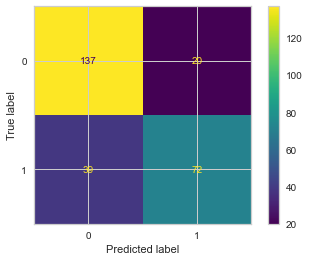

In [56]:
plot_confusion_matrix(rf3, X_test, y_test)
plt.show()

#### ROC Curve

In [57]:
roc_auc_score(y_test, y_pred)

0.7606300568084008

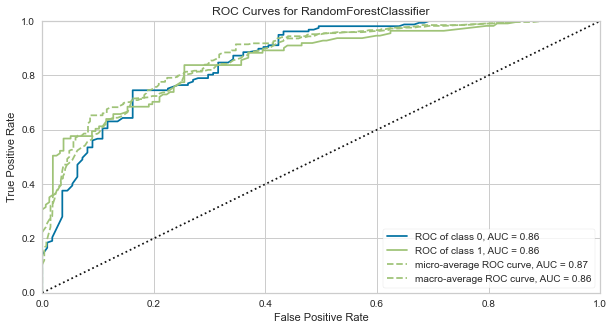

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
roc_viz = ROCAUC(rf3)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.poof()

#### Learning curve

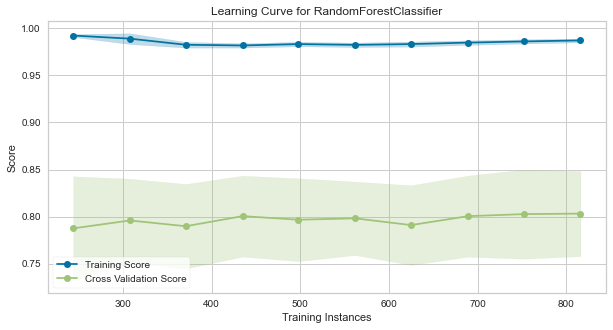

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    rf3, cv=cv,
    train_sizes=sizes,
    scoring='f1_weighted',
    n_jobs=-1,
    ax=ax
)

lc_viz.fit(X, y)
lc_viz.poof()

## Chapter 4. Missing data

#### Examining missing data

In [60]:
orig_df.isnull().mean()*100

survived     0.000000
pclass       0.000000
name         0.000000
sex          0.000000
age         19.865320
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000000
cabin       77.104377
embarked     0.224467
dtype: float64

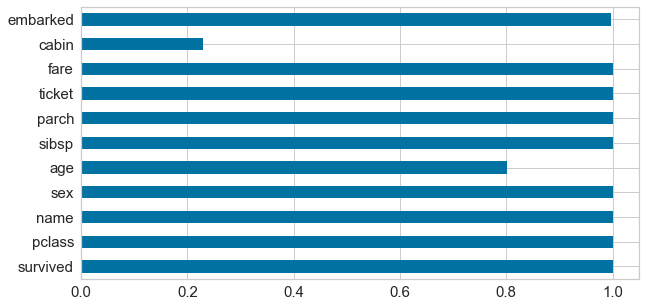

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
(1 - orig_df.isnull().mean()).plot.barh(ax=ax)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Imputing data

In [62]:
from sklearn.impute import SimpleImputer

In [63]:
num_cols = orig_df.select_dtypes(include='number').columns
im = SimpleImputer()
imputed = im.fit_transform(orig_df[num_cols])
imputed.shape

(891, 6)

#### Adding indicator column

In [64]:
def add_indicator(col):
    def wrapper(df):
        return df[col].isna().astype(int)
    return wrapper

df1 = orig_df.assign(cabin_missing=add_indicator('cabin'))

In [65]:
df1.cabin.isna().sum(), df1['cabin_missing'].sum()

(687, 687)

## Chapter 5. Cleaning data

#### Column names

In [66]:
bad_df = pd.DataFrame({
    "A": [1, None, 3],
    " sales numbers ": [20.0, 30.0, None],
})

# will raise error becouse of surraunding spaces
# bad_df['sales number']

bad_df

,A,sales numbers
0,1.0,20.0
1,NaN,30.0
2,3.0,NaN


In [67]:
def clean_col(name):
    return name.strip().lower().replace(' ', '_')

In [68]:
good_df = bad_df.rename(columns=clean_col)
good_df

,a,sales_numbers
0,1.0,20.0
1,NaN,30.0
2,3.0,NaN


In [69]:
good_df.sales_numbers

0    20.0
1    30.0
2     NaN
Name: sales_numbers, dtype: float64

#### Replacing missing values

In [70]:
bad_df.fillna(42)

,A,sales numbers
0,1.0,20.0
1,42.0,30.0
2,3.0,42.0


In [71]:
# check if there any NA values 
df.isna().any().any()

True

## Chapter 6. Exploring

In [72]:
X_copy = X.copy()
X_copy['target'] = y

#### Histogram

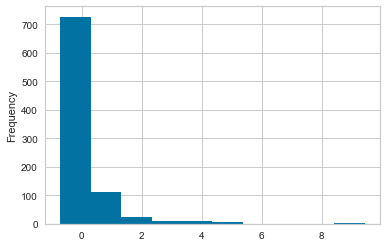

In [73]:
fig, ax = plt.subplots(figsize=(6, 4))
X.fare.plot(kind='hist')
plt.show()

C:\Users\admin\anaconda3\envs\mlall\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\admin\anaconda3\envs\mlall\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


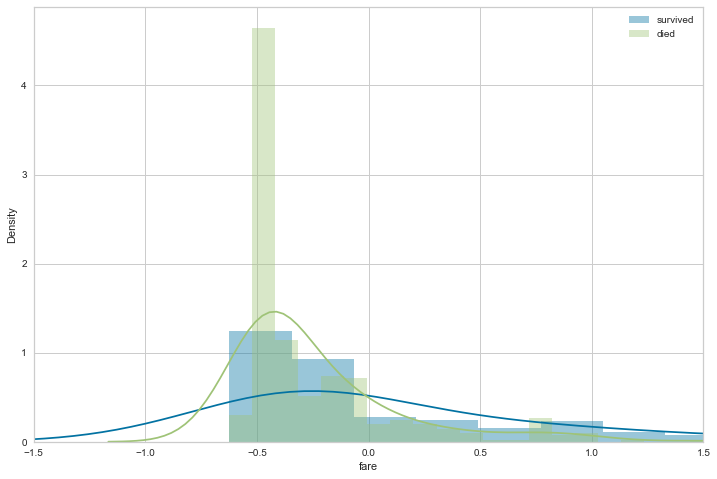

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.distplot(X_train[y_train == 1].fare, label='survived')
ax = sns.distplot(X_train[~(y_train == 1)].fare, label='died')
ax.set_xlim(-1.5, 1.5)
ax.legend()

#### Scatter plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


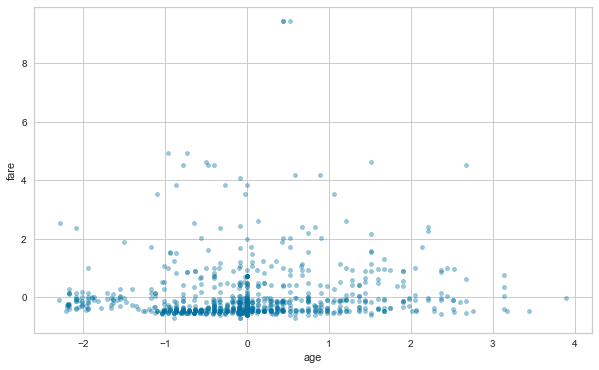

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
X.plot.scatter(x='age', y='fare', ax=ax, alpha=0.4)

In [76]:
X.age.corr(X.fare)

0.0927616469489705

#### Joint plot

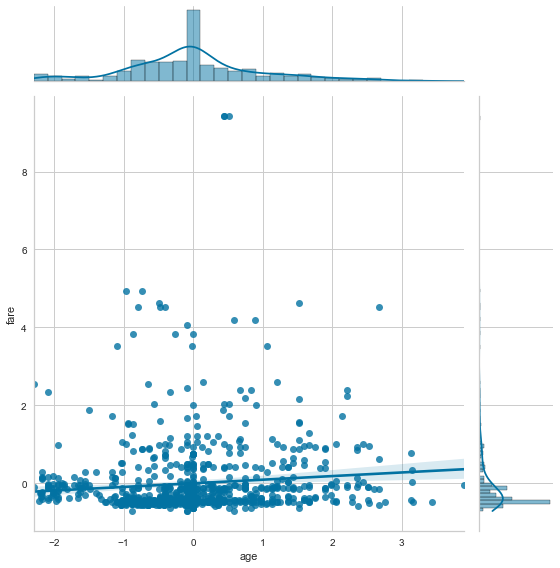

In [77]:
# fig, ax = plt.subplots(figsize=(8, 8))
sns.jointplot(x='age', y='fare', data=X_copy, kind='reg', height=8, ratio=5)

#### Pair grid

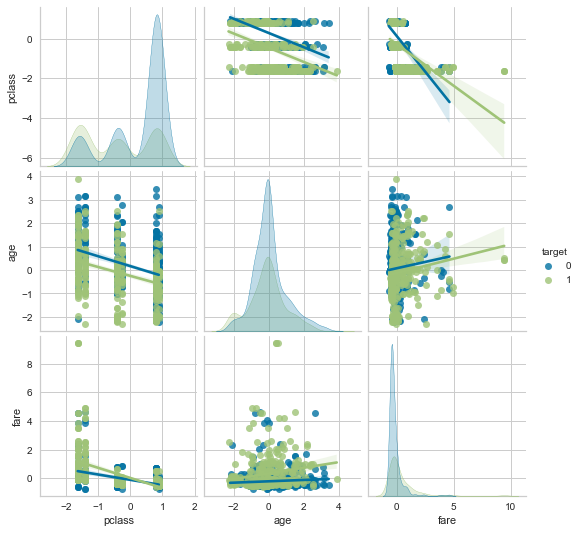

In [78]:
cols = ['pclass', 'age', 'fare']
sns.pairplot(data=X_copy, vars=cols, hue='target', kind='reg')

#### Box and violin plots

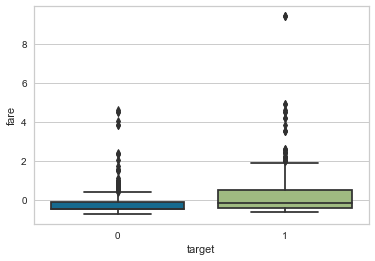

In [79]:
sns.boxplot(x='target', y='fare', data=X_copy)

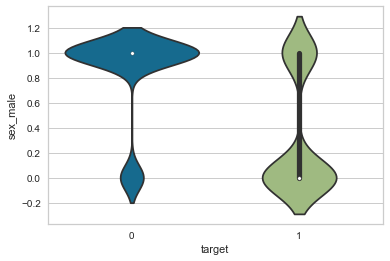

In [80]:
sns.violinplot(x='target', y='sex_male', data=X_copy)

#### Comparing two ordinal values

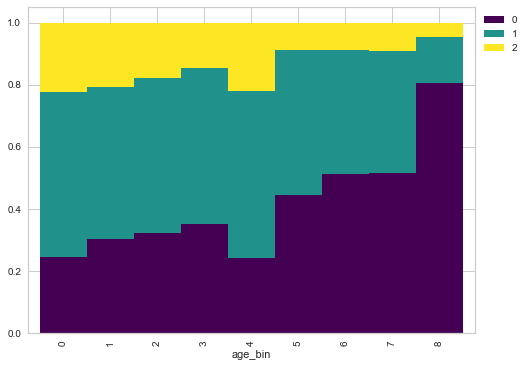

In [81]:
fig, ax = plt.subplots(figsize=(8, 6))

X.assign(
    age_bin=pd.qcut(X.age, q=10, labels=False, duplicates='drop'),
    class_bin=pd.qcut(X.pclass, q=3, labels=False)
)\
.groupby(['age_bin', 'class_bin'])\
.size()\
.unstack()\
.pipe(lambda df: df.div(df.sum(1), axis=0))\
.plot.bar(
    stacked=True,
    width=1,
    ax=ax,
    cmap='viridis'
)\
.legend(bbox_to_anchor=(1, 1))

#### Correlation

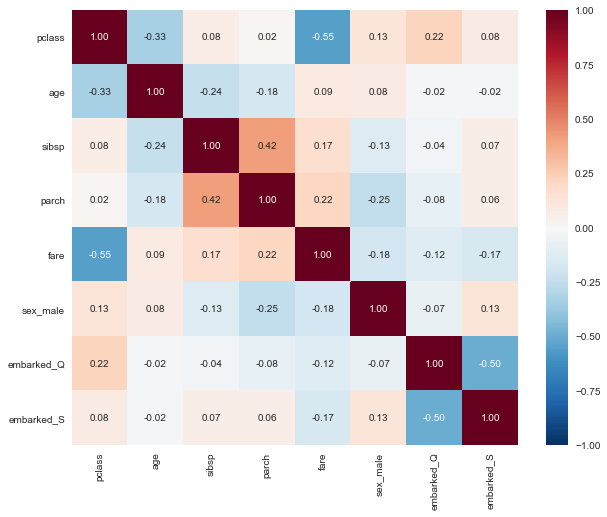

In [82]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    X.corr(),
    vmin=-1,
    vmax=1,
    fmt='.2f',
    annot=True,
    cmap='RdBu_r',
    
    ax=ax)
plt.show()

In [83]:
def correlated_columns(df, threshold=0.95):
    return (
        df.corr()\
        .pipe(
            lambda df1: pd.DataFrame(
            np.tril(df1, k=-1),
            columns=df.columns,
            index=df.columns,
            )
        )\
        .stack()\
        .rename("pearson")\
        .pipe(
            lambda s: s[
            s.abs() > threshold
            ].reset_index()
            
        )\
#         .query("level_0 not in level_1")
    )


correlated_columns(X, threshold=0.45).style.format({'pearson':'{:.2f}'})

,level_0,level_1,pearson
0,fare,pclass,-0.55
1,embarked_S,embarked_Q,-0.50


#### RadViz

In [84]:
from pandas.plotting import radviz

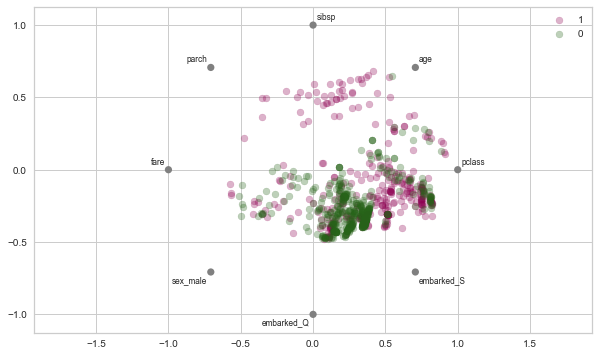

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))
radviz(X_copy, 'target', ax=ax, colormap='PiYG', alpha=0.3)

#### Parallel coordinates

In [86]:
from pandas.plotting import parallel_coordinates

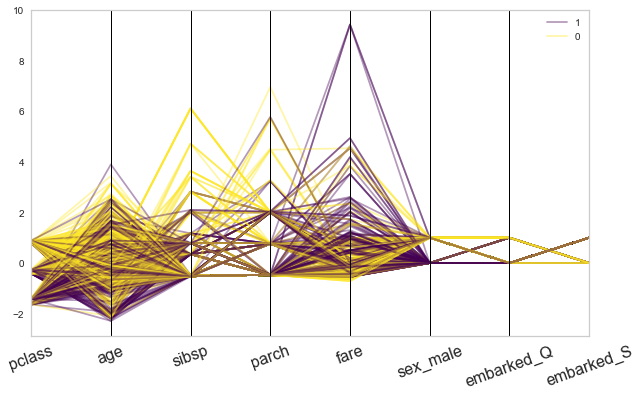

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))
parallel_coordinates(
    X_copy,
    'target',
    ax=ax,
    colormap='viridis',
    alpha=0.4
)
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size': 16}, rotation=20)
plt.show()

## Chapter 7. Preprocess data

In [88]:
X2 = pd.DataFrame(
    {
        'a': range(5),
        'b': [-100, -50, 0, 200, 1000],
    }
)

X2

,a,b
0,0,-100
1,1,-50
2,2,0
3,3,200
4,4,1000


#### Standardize

In [89]:
# sklearn
std = preprocessing.StandardScaler()
std.fit_transform(X2)

array([[-1.41421356, -0.75995002],
       [-0.70710678, -0.63737744],
       [ 0.        , -0.51480485],
       [ 0.70710678, -0.02451452],
       [ 1.41421356,  1.93664683]])

In [90]:
std.scale_

array([  1.41421356, 407.92156109])

In [91]:
std.mean_

array([  2., 210.])

In [92]:
std.var_

array([2.000e+00, 1.664e+05])

In [93]:
# pandas
X2_std = (X2 - X2.mean()) / X2.std()
X2_std

,a,b
0,-1.264911,-0.679720
1,-0.632456,-0.570088
2,0.000000,-0.460455
3,0.632456,-0.021926
4,1.264911,1.732190


In [94]:
X2_std.mean()

a    4.440892e-17
b    0.000000e+00
dtype: float64

In [95]:
X2_std.std()

a    1.0
b    1.0
dtype: float64

#### Scale to range

In [96]:
# sklearn
mms = preprocessing.MinMaxScaler()
mms.fit_transform(X2)

array([[0.        , 0.        ],
       [0.25      , 0.04545455],
       [0.5       , 0.09090909],
       [0.75      , 0.27272727],
       [1.        , 1.        ]])

In [97]:
# pandas
(X2 - X2.min()) / (X2.max() - X2.min())

,a,b
0,0.00,0.000000
1,0.25,0.045455
2,0.50,0.090909
3,0.75,0.272727
4,1.00,1.000000


#### Dummy variables (one-hot encoding)

In [98]:
X_cat = pd.DataFrame(
    {
        "name": ["George", "Paul"],
        "inst": ["Bass", "Guitar"],
    } 
)

X_cat

,name,inst
0,George,Bass
1,Paul,Guitar


In [99]:
pd.get_dummies(X_cat) # drop_first=True

,name_George,name_Paul,inst_Bass,inst_Guitar
0,1,0,1,0
1,0,1,0,1


#### Label encoder

In [100]:
# sklearn
le = preprocessing.LabelEncoder()
le.fit_transform(X_cat.loc[:, 'inst'])

array([0, 1])

In [101]:
le.inverse_transform([0, 1, 1, 0])

array(['Bass', 'Guitar', 'Guitar', 'Bass'], dtype=object)

In [102]:
# pandas

In [103]:
X_cat.name.astype('category').cat.as_ordered().cat.codes + 1

0    1
1    2
dtype: int8

#### Frequency encoding

In [104]:
# X_cat = X_cat.append({'name':'George', 'inst':'Gitar'}, ignore_index=True)
X_cat

,name,inst
0,George,Bass
1,Paul,Guitar


In [105]:
mapping = X_cat.name.value_counts()
mapping

Paul      1
George    1
Name: name, dtype: int64

In [106]:
X_cat.name.map(mapping)

0    1
1    1
Name: name, dtype: int64

#### Pulling categories from strings

In [107]:
from collections import Counter

In [111]:
c = Counter()
def triples(val):
    for i in range(len(val)):
        c[val[i : i + 3]] += 1
        
orig_df.name.apply(triples)
c.most_common(10)

[(', M', 870),
 (' Mr', 642),
 ('r. ', 568),
 ('Mr.', 517),
 ('s. ', 309),
 ('n, ', 218),
 (' Mi', 197),
 ('iss', 183),
 ('ss.', 183),
 ('Mis', 182)]

In [112]:
orig_df.name.str.extract('([A-Za-z]+)\.').value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Mme           1
Ms            1
Capt          1
Lady          1
Jonkheer      1
Don           1
Countess      1
Sir           1
dtype: int64

#### Other categorical encoding

In [ ]:
# TODO
# pandas.df.replace
#

In [ ]:
X['cat_embarked'] = X.embarked.astype('category').cat.codes
X.head()

In [ ]:
X.embarked.astype('category').cat.categories

#### Add col_na feature

In [ ]:
data = pd.DataFrame({"A": [0, None, 5, 100]})
data["A_na"] = data.A.isnull()
data["A"] = data.A.fillna(data.A.median())

data

#### Manual feature engineering

In [ ]:
cab_age = df.loc[:, ['age', 'cabin']].groupby('cabin').agg('min,max,mean,sum'.split(','))['age']
cab_age.head()

In [ ]:
cab_age[(cab_age['min'] != cab_age['sum']) & (cab_age['sum'] != 0)].head()

In [ ]:
agg = (
    df.groupby("cabin")\
    .agg("min,max,mean,sum".split(","))\
    .reset_index()
)
agg.head(3)

In [ ]:
agg.columns = ['_'.join(cols).strip('_') 
               for cols in agg.columns.values]
agg.head(3)

In [ ]:
agg_df = df.merge(agg, on="cabin")
agg_df.head(1)

## Chapter 8. Feature selection

#### Collinear columns

In [ ]:
limit = 0.95
corr = agg_df.corr()

mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
mask[:5, :9]

In [ ]:
corr_no_diag = corr.where(mask)
corr_no_diag.head()

In [ ]:
cols = [
    col
    for col in corr_no_diag.columns
    if any(abs(corr_no_diag[col]) > limit)
]
cols

Tool to visualize feature importance:<br>
https://github.com/parrt/random-forest-importances

#### Lasso regression

In [ ]:
from sklearn import linear_model

In [ ]:

X_train

In [ ]:
model = linear_model.LassoLarsCV(cv=10, max_n_alphas=10).fit(X_train, y_train)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
cm = iter(
    plt.get_cmap("tab20")(np.linspace(0, 1, X.shape[1]))
)

for i in range(X.shape[1]):
    c = next(cm)
    ax.plot(
        model.alphas_,
        model.coef_path_.T[:, i],
        c=c,
        alpha=0.8,
        label=X.columns[i],
    )

ax.axvline(
    model.alpha_,
    linestyle='-',
    c='k',
    label='alphaCV',
)

plt.ylabel("Regression Coefficients")
ax.legend(X.columns, bbox_to_anchor=(1, 1))
plt.xlabel("alpha")
plt.title("Regression Coefficients Progression for Lasso Paths")

    
plt.show()

#### Recursive feature elimination

In [ ]:
from yellowbrick.features import RFECV
from sklearn.feature_selection import RFE

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
rfe = RFECV(
    ensemble.RandomForestClassifier(
        n_estimators=100
    ),
    cv=5,
    ax=ax
)

rfe.fit(X, y)

rfe.poof()

In [ ]:
rfe.rfe_estimator_.ranking_

In [ ]:
rfe.n_features_

In [ ]:
rfe.rfe_estimator_.support_

In [ ]:
model = ensemble.RandomForestClassifier(n_estimators=100)
rfe = RFE(model, n_features_to_select=6)
rfe.fit(X, y)

In [ ]:
X.columns[rfe.support_]

#### Mutual information

In [ ]:
mic = feature_selection.mutual_info_classif(X, y)
mic

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
pd.DataFrame({'feature': X.columns, 'vimp': mic})\
    .set_index('feature')\
    .plot.barh(ax=ax)

plt.show()

#### Principal component analysis

#### Feature importance

Most tree models provide access to a `.feature_importances_` attribute<br>
following training. A higher importance typically means that there is higher<br>
error when the feature is removed from the model.

## Chapter 9. Imbalanced classes

#### Use a different metric

One hint is to use a measure other than accuracy (`AUC` is a good choice) for<br>
calibrating models. `Precision` and `recall` are also better options when the<br>
target sizes are different. However, there are other options to consider as<br>
well.


#### Penalize models

Many **scikit-learn** classification models support the `class_weight`<br>
parameter. Setting this to `'balanced'` will attempt to regularize minority<br>
classes and incentivize the model to classify them correctly. Alternatively,<br>
you can `grid search` and specify the weight options by passing in a dictionary<br>
mapping class to weight (give higher weight to smaller classes).<br>
<br>
The **XGBoost** library has the `max_delta_step` parameter, which can be set<br>
from 1 to 10 to make the update step more conservative. It also has the<br>
`scale_pos_weight` parameter that sets the ratio of negative to positive<br>
samples (for binary classes). Also, the `eval_metric should be set to 'auc'`<br>
rather than the default value of 'error' for classification.<br>
<br>
The **KNN** model has a weights parameter that can bias neighbors that are<br>
closer. If the minority class samples are close together, setting this parameter<br>
to 'distance' may improve performance.


#### Upsampling minority

In [ ]:
from sklearn.utils import resample

In [ ]:
mask = df.survived == 1
surv_df = df[mask]
died_df = df[~mask]

In [ ]:
df_upsample = resample(
    surv_df,
    replace=True,
    n_samples=len(died_df),
    random_state=42,
)

In [ ]:
df_upsample.shape, surv_df.shape

In [ ]:
died_df.shape

In [ ]:
surv_df.head(3)

In [ ]:
df_upsample.head(3)

In [ ]:
surv_df.loc[[289]]

In [ ]:
df_upsample.loc[[289]]

#### Generate minority data

The `imbalanced-learn` library can also generate new samples of minority<br>
classes with both the Synthetic Minority Over-sampling Technique (SMOTE)<br>
and Adaptive Synthetic (ADASYN) sampling approach algorithms. SMOTE<br>
works by choosing one of its k-nearest neighbors, connecting a line to one of<br>
them, and choosing a point along that line. ADASYN is similar to SMOTE,<br>
but generates more samples from those that are harder to learn. The classes<br>
in imbanced-learn are named over_sampling.SMOTE and<br>
over_sampling.ADASYN.


#### Downsampling majority

Same as Upsampling minority but swap surv_df with died_df and set replace=False

## Chapter 10. Classification

### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
from yellowbrick.model_selection import FeatureImportances

In [21]:
lr = LogisticRegression(random_state=24)

lr.fit(X_train, y_train)

In [24]:
lr.score(X_test, y_test)

0.8022388059701493

In [32]:
lr.predict(X.iloc[[0]]).item(), y.iloc[[0]].values.item()

(1, 1)

In [33]:
lr.predict_proba(X.iloc[[0]])

array([[0.36929948, 0.63070052]])

In [34]:
lr.predict_log_proba(X.iloc[[0]])

array([[-0.99614737, -0.46092414]])

In [35]:
lr.decision_function(X.iloc[[0]])

array([0.53522323])

In [36]:
lr.intercept_

array([1.32916443])

In [38]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

inv_logit(lr.intercept_)

array([0.79070239])

In [40]:
lr.coef_[0]

array([-0.74919638, -0.431079  , -0.32040534, -0.06743026,  0.13493327,
       -2.46799604, -0.10267541, -0.5389964 ])

In [42]:
cols = X.columns
for col, val in sorted(
    zip(cols, lr.coef_[0]),
    key=lambda x: x[1],
    reverse=True,):
    
    print(f"{col:10}{val:10.3f} {inv_logit(val):10.3f}")

fare           0.135      0.534
parch         -0.067      0.483
embarked_Q    -0.103      0.474
sibsp         -0.320      0.421
age           -0.431      0.394
embarked_S    -0.539      0.368
pclass        -0.749      0.321
sex_male      -2.468      0.078


C:\Users\admin\AppData\Roaming\Python\Python38\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


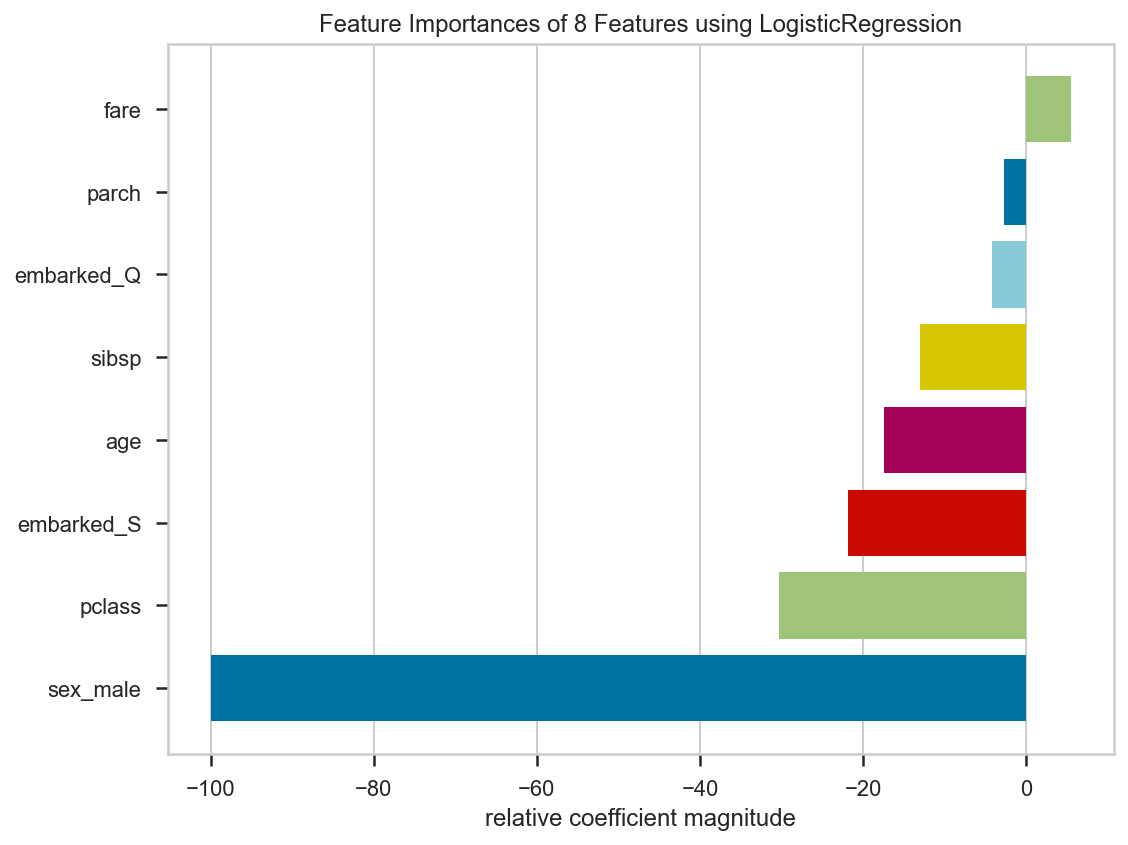

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
viz = FeatureImportances(lr)
viz.fit(X, y)
viz.poof()
plt.show()

### Naive Bayes

`zero probability problem`

In [54]:
from sklearn.naive_bayes import GaussianNB

In [55]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [56]:
nb.score(X_test, y_test)

0.7910447761194029

In [57]:
nb.predict(X.iloc[[0]])

array([1], dtype=int64)

In [58]:
nb.predict_proba(X.iloc[[0]])

array([[0.20678601, 0.79321399]])

### Support Vector Machine

In [59]:
from sklearn.svm import SVC

In [60]:
svc = SVC(random_state=1, probability=True)
svc.fit(X_train, y_train)

SVC(probability=True, random_state=1)

In [61]:
svc.score(X_test, y_test)

0.8097014925373134

In [62]:
svc.predict(X.iloc[[0]])

array([1], dtype=int64)

In [63]:
svc.predict_proba(X.iloc[[0]])

array([[0.13921272, 0.86078728]])

### K-Nearest Neighbor

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

KNeighborsClassifier()

In [66]:
knc.score(X_test, y_test)

0.8022388059701493

In [67]:
knc.predict(X.iloc[[0]])

array([1], dtype=int64)

In [68]:
knc.predict_proba(X.iloc[[0]])

array([[0.2, 0.8]])

### Decision tree

In [30]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [31]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [32]:
dt.score(X_test, y_test)

0.8208955223880597

In [16]:
dt.predict(X_test.iloc[[0]])

array([0], dtype=int64)

In [17]:
y_test.iloc[[0]]

PassengerId
710    1
Name: survived, dtype: int64

In [18]:
dt.predict_proba(X_test.iloc[[0]])

array([[0.86918605, 0.13081395]])

In [19]:
dt.predict_log_proba(X_test.iloc[[0]])

array([[-0.14019808, -2.03397917]])

In [20]:
dt.feature_importances_

array([0.18244614, 0.0865423 , 0.04816438, 0.        , 0.08880583,
       0.59404135, 0.        , 0.        ])

In [21]:
dt.tree_

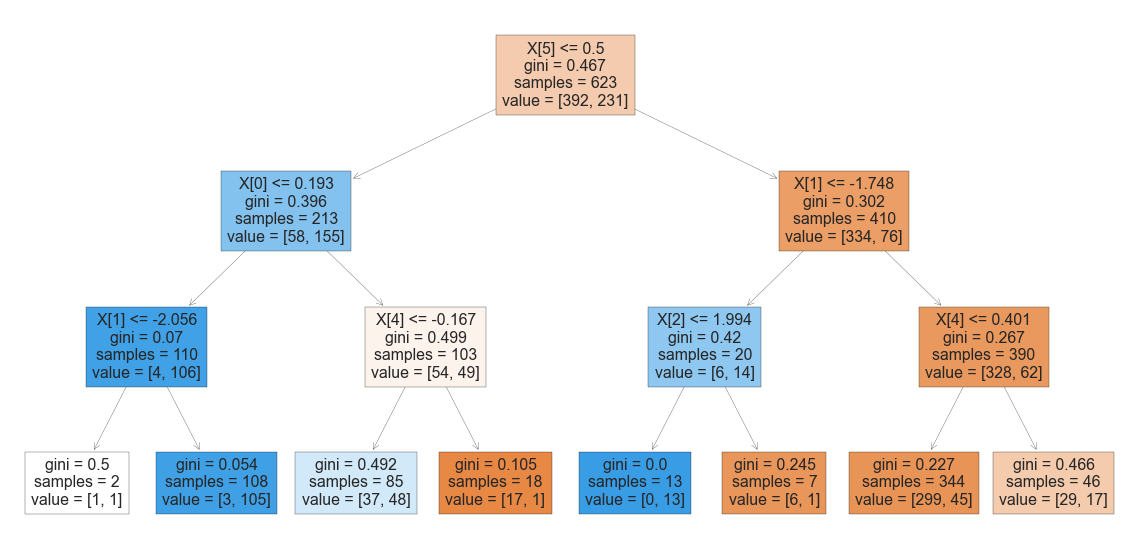

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt, filled=True)
plt.show()

### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rfc = RandomForestClassifier(random_state=1, max_depth=4)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=1)

In [35]:
rfc.score(X_test, y_test)

0.8134328358208955

In [36]:
rfc.score(X_train, y_train)

0.8523274478330658

In [30]:
rfc.feature_importances_

array([0.08121073, 0.25288285, 0.05305931, 0.04183277, 0.27678328,
       0.25408139, 0.01132368, 0.02882598])

### XGBoost

In [113]:
import xgboost as xgb

In [114]:
xgbc = xgb.XGBClassifier(random_state=1, use_label_encoder=False)
xgbc.fit(X_train, y_train,
         eval_metric='error',
         early_stopping_rounds=1, 
         eval_set=[(X_train, y_train)])

[0]	validation_0-error:0.12199
[1]	validation_0-error:0.12039


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [115]:
xgbc.score(X_test, y_test)

0.8246268656716418

In [116]:
xgbc.score(X_train, y_train)

0.8796147672552167

In [117]:
xgbc.feature_importances_

array([0.11896342, 0.02026116, 0.03575357, 0.01795938, 0.02320729,
       0.7559116 , 0.        , 0.02794352], dtype=float32)

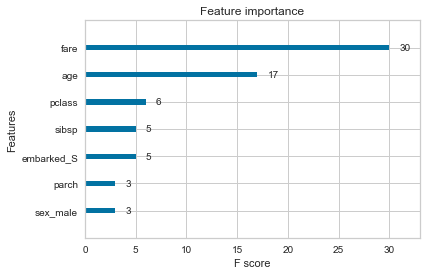

In [118]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(xgbc, ax=ax)
plt.show()

In [119]:
booster = xgbc.get_booster()

In [120]:
print(booster.get_dump()[0])

0:[sex_male<1] yes=1,no=2,missing=1
	1:[pclass<0.192980036] yes=3,no=4,missing=3
		3:leaf=0.536842108
		4:[fare<-0.166529298] yes=7,no=8,missing=7
			7:[embarked_S<1] yes=13,no=14,missing=13
				13:[fare<-0.322984725] yes=19,no=20,missing=19
					19:[fare<-0.465955198] yes=31,no=32,missing=31
						31:leaf=0.25
						32:leaf=-0.200000018
					20:leaf=0.41538465
				14:[fare<-0.412183017] yes=21,no=22,missing=21
					21:[fare<-0.473473877] yes=33,no=34,missing=33
						33:leaf=0.300000012
						34:leaf=-0.288888901
					22:[fare<-0.277343154] yes=35,no=36,missing=35
						35:leaf=0.247058839
						36:leaf=-0.100000009
			8:leaf=-0.436363667
	2:[age<-1.74828959] yes=5,no=6,missing=5
		5:[sibsp<1.99438357] yes=9,no=10,missing=9
			9:leaf=0.458823562
			10:leaf=-0.272727281
		6:[fare<0.400820017] yes=11,no=12,missing=11
			11:[pclass<-1.02759421] yes=15,no=16,missing=15
				15:[fare<-0.0213925578] yes=23,no=24,missing=23
					23:[fare<-0.0390443206] yes=37,no=38,missing=37
						37:leaf=-0

### Gradient Boosted with LightGBM

https://lightgbm.readthedocs.io/en/latest/index.html

### TPOT

In [16]:
from tpot import TPOTClassifier

In [18]:
tc = TPOTClassifier(generations=2, population_size=50, verbosity=2, n_jobs=6)
tc.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/150 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8266193548387099

Best pipeline: ExtraTreesClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=True, criterion=entropy, max_features=0.8500000000000001, min_samples_leaf=10, min_samples_split=19, n_estimators=100)


TPOTClassifier(generations=2, n_jobs=6, population_size=50, verbosity=2)

In [19]:
tc.score(X_test, y_test)

0.8059701492537313

In [21]:
tc.score(X_train, y_train)

0.8394863563402889

In [23]:
print(tc.export())

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8266193548387099
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.8500000000000001, min_samples_leaf=10, min_samples_split=19, n_estimators=100)
)

exported_pipeline.fit(training_features, training_target)
resul

## Chapter 11. Model Selection

### Validation curve

In [24]:
from yellowbrick.model_selection import ValidationCurve

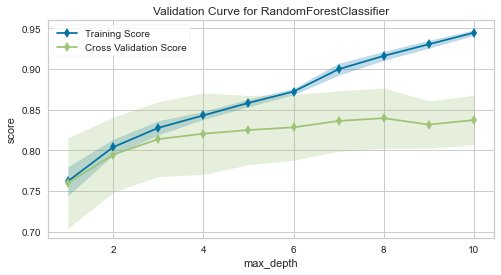

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
vc_viz = ValidationCurve(
    RandomForestClassifier(),
    param_name='max_depth',
    param_range=np.arange(1, 11),
    cv=10,
    n_jobs=5
)

vc_viz.fit(X, y)
vc_viz.poof()
plt.show()

### Learning curve

In [28]:
from yellowbrick.model_selection import LearningCurve

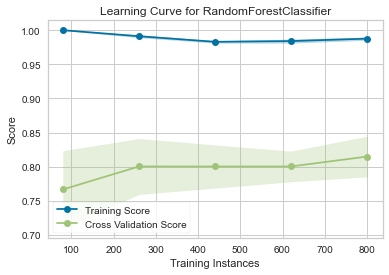

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
lc_viz = LearningCurve(
    RandomForestClassifier(),
    cv=10,
)
lc_viz.fit(X, y)
lc_viz.poof()
plt.show()

## Chapter 12. Metrics and Classification Evaluation

### Confusion matrix

In [47]:
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix

In [35]:
y_pred = dt.predict(X_test)

In [54]:
# True positives
tp = ((y_test == 1) & (y_pred == y_test)).sum()
tp

79

In [55]:
# True negatives
tn = ((y_test == 0) & (y_pred == y_test)).sum()
tn

141

In [56]:
# False positives
fp = ((y_test == 0) & (y_pred != y_test)).sum()
fp

16

In [57]:
# False negatives
fn = ((y_test == 1) & (y_pred != y_test)).sum()
fn

32

In [45]:
confusion_matrix(y_test, y_pred)

array([[141,  16],
       [ 32,  79]], dtype=int64)

In [46]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted died', 'Predicted survived'],
    index=['Died', 'Survived']
)

,Predicted died,Predicted survived
Died,141,16
Survived,32,79


In [49]:
classes = ['died', 'survived']
mapping = {i: clas for i, clas in enumerate(classes)}

mapping

{0: 'died', 1: 'survived'}

C:\Users\admin\AppData\Roaming\Python\Python38\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


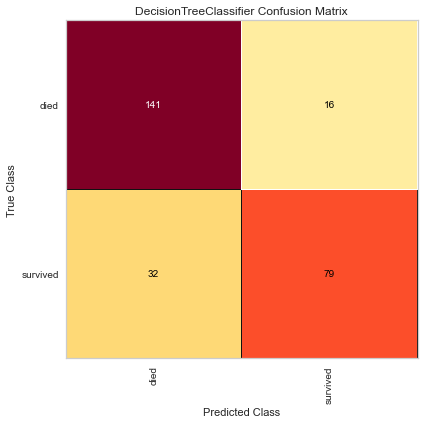

In [53]:
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(dt, 
                         classes=classes, 
                         label_encoder=mapping)
cm_viz.score(X_test, y_test)
cm_viz.poof()
plt.show()

### Metrics

- `'accuracy'`<br>
Percent of correct predictions
<br><br>
- `'average_precision'`<br>
Precision recall curve summary
<br><br>
- `'f1'`<br>
Harmonic mean of precision and recall
<br><br>
- `'neg_log_loss'`<br>
Logistic or cross-entropy loss (model must support predict_proba)
<br><br>
- `'precision'`<br>
is the percent of positive predictions that were correct (TP divided
by (TP + FP)) (not label a negative as a positive)
<br><br>
- `'recall'`<br>
Ability to find all positive samples
<br><br>
- `'roc_auc'`<br>
Area under the receiver operator characteristic curve


#### Accuracy

In [60]:
from sklearn.metrics import accuracy_score

In [59]:
(tp + tn) / (tp + fp + tn + fn)

0.8208955223880597

In [61]:
accuracy_score(y_test, y_pred)

0.8208955223880597

#### Recall *(sensitivity)*

In [63]:
from sklearn.metrics import recall_score

In [64]:
tp / (tp + fn)

0.7117117117117117

In [65]:
recall_score(y_test, y_pred)

0.7117117117117117

#### Precision

In [66]:
from sklearn.metrics import precision_score

In [67]:
tp / (tp + fp)

0.8315789473684211

In [68]:
precision_score(y_test, y_pred)

0.8315789473684211

#### F1

In [69]:
from sklearn.metrics import f1_score

In [70]:
pre = tp / (tp + fp)
rec = tp / (tp + fn)

(2 * pre * rec) / (pre + rec)

0.7669902912621359

In [71]:
f1_score(y_test, y_pred)

0.7669902912621359

#### Classification report

In [72]:
from yellowbrick.classifier import ClassificationReport

C:\Users\admin\AppData\Roaming\Python\Python38\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


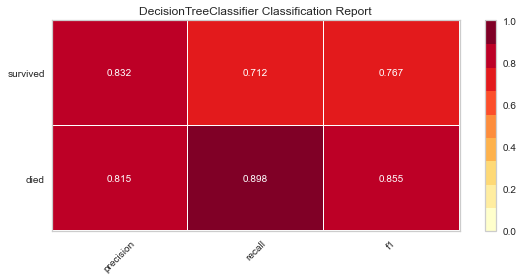

In [86]:
fig, ax = plt.subplots(figsize=(8, 4))
cr = ClassificationReport(dt, 
                          classes=['died', 'survived'])
cr.score(X_test, y_test)
cr.poof()
plt.show()

#### ROC

In [87]:
from sklearn.metrics import roc_auc_score
from yellowbrick.classifier import ROCAUC

In [88]:
roc_auc_score(y_test, y_pred)

0.8049004418431169

#### Precision-recall curve

In [92]:
from sklearn.metrics import average_precision_score
from yellowbrick.classifier import PrecisionRecallCurve

In [93]:
average_precision_score(y_test, y_pred)

0.7112474611296292

0.7842916686434941


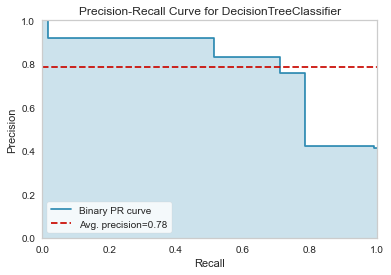

In [97]:
fig, ax = plt.subplots(figsize=(6, 4))
viz = PrecisionRecallCurve(
    DecisionTreeClassifier(max_depth=3)
)

viz.fit(X_train, y_train)
print(viz.score(X_test, y_test))
viz.poof()
plt.show()

#### Cumulative gains plot

In [100]:
# The scikit-plot library can create a cumulative gains plot
#  scikitplot.metrics.plot_cumulative_gain

#### Lift curve

In [101]:
#  scikitplot.metrics.plot_lift_curve

#### Class balance

In [102]:
from yellowbrick.classifier import ClassBalance

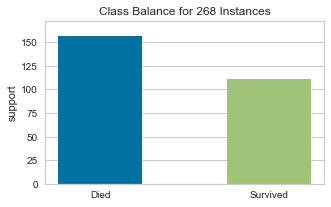

In [104]:
fig, ax = plt.subplots(figsize=(5, 3))
viz = ClassBalance(ax=ax, labels=['Died', 'Survived'])
viz.fit(y_test)
viz.poof()
plt.show()

#### Class prediction error

In [105]:
from yellowbrick.classifier import ClassPredictionError

C:\Users\admin\AppData\Roaming\Python\Python38\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


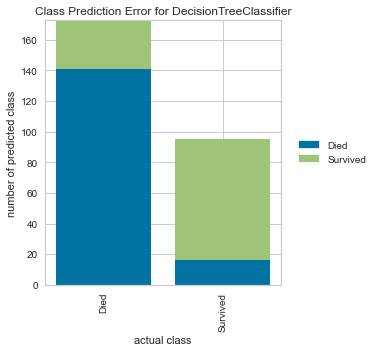

In [110]:
fig, ax = plt.subplots(figsize=(6, 5))
viz = ClassPredictionError(dt, classes=['Died', 'Survived'])
viz.score(X_test, y_test)
viz.poof()
plt.show()

#### Discrimination threshold

In [111]:
from yellowbrick.classifier import DiscriminationThreshold

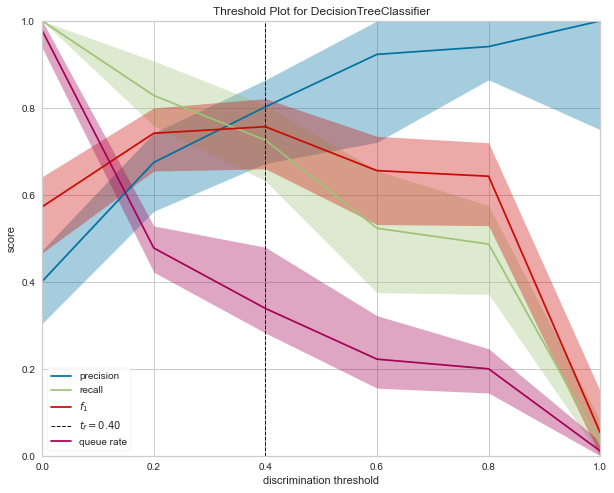

In [114]:
fig, ax = plt.subplots(figsize=(10, 8))
viz = DiscriminationThreshold(dt)
viz.fit(X, y)
viz.poof()
plt.show()

## Chapter 13. Explaining models

https://github.com/marcotcr/lime
<br>
https://github.com/andosa/treeinterpreter
<br>
https://pdpbox.readthedocs.io/en/latest/
<br>
https://shap.readthedocs.io/en/latest/index.html
<br>
`Surrogate Models`

## Chapter 14. Regression

In [2]:
from sklearn.datasets import load_boston

In [3]:
b = load_boston()

In [4]:
b.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [5]:
bos_X = pd.DataFrame(b.data, columns=b.feature_names)

In [6]:
bos_y = b.target

In [7]:
bos_X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [8]:
bX_train, bX_test, by_train, by_test = train_test_split(bos_X, bos_y, 
                                                        test_size=0.3, 
                                                        random_state=42)

In [9]:
bos_sX = preprocessing.StandardScaler().fit_transform(bos_X)

In [10]:
bos_sX = pd.DataFrame(bos_sX, columns=bos_X.columns)
bos_sX.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02
mean,-5.616939e-17,6.319056e-17,-3.145486e-15,-2.106352e-17,2.752300e-15,-1.150770e-14,-1.137430e-15,7.582867e-16,5.616939e-17,5.616939e-17,-1.022283e-14,8.593916e-15,-5.897786e-16
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00
min,-4.197819e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990e+00,-2.707379e+00,-3.907193e+00,-1.531127e+00
25%,-4.109696e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-7.675760e-01,-4.880391e-01,2.050715e-01,-7.994200e-01
50%,-3.906665e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-4.646726e-01,2.748590e-01,3.811865e-01,-1.812536e-01
75%,7.396560e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926e+00,8.065758e-01,4.336510e-01,6.030188e-01
max,9.933931e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194e+00,1.638828e+00,4.410519e-01,3.548771e+00


In [11]:
bsX_train, bsX_test, bsy_train, bsy_test = train_test_split(bos_sX, bos_y, 
                                                        test_size=0.3, 
                                                        random_state=42)

### Baseline model

In [42]:
import pydotplus

from io import StringIO
from sklearn.dummy import DummyRegressor

from yellowbrick.features import FeatureImportances

In [13]:
dr = DummyRegressor()
dr.fit(bX_train, by_train)
dr.score(bX_test, by_test)

-0.03469753992352409

### Linear regression

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
lr = LinearRegression(n_jobs=5)
lr.fit(bX_train, by_train)
lr.score(bX_test, by_test)

0.7112260057484907

In [16]:
lr.coef_

array([-1.33470103e-01,  3.58089136e-02,  4.95226452e-02,  3.11983512e+00,
       -1.54170609e+01,  4.05719923e+00, -1.08208352e-02, -1.38599824e+00,
        2.42727340e-01, -8.70223437e-03, -9.10685208e-01,  1.17941159e-02,
       -5.47113313e-01])

In [17]:
lr.intercept_

31.63108403569312

In [18]:
lr_pred = lr.predict(bX_test)

In [19]:
lr2 = LinearRegression()
lr2.fit(bsX_train, bsy_train)
lr2.score(bsX_test, bsy_test)

0.7112260057484923

In [20]:
lr2.intercept_

22.50945471291039

In [21]:
lr2.coef_

array([-1.14691411,  0.83432605,  0.33940694,  0.79163612, -1.784727  ,
        2.84783949, -0.30429306, -2.91562521,  2.11140045, -1.46519951,
       -1.9696347 ,  1.07567771, -3.90310727])

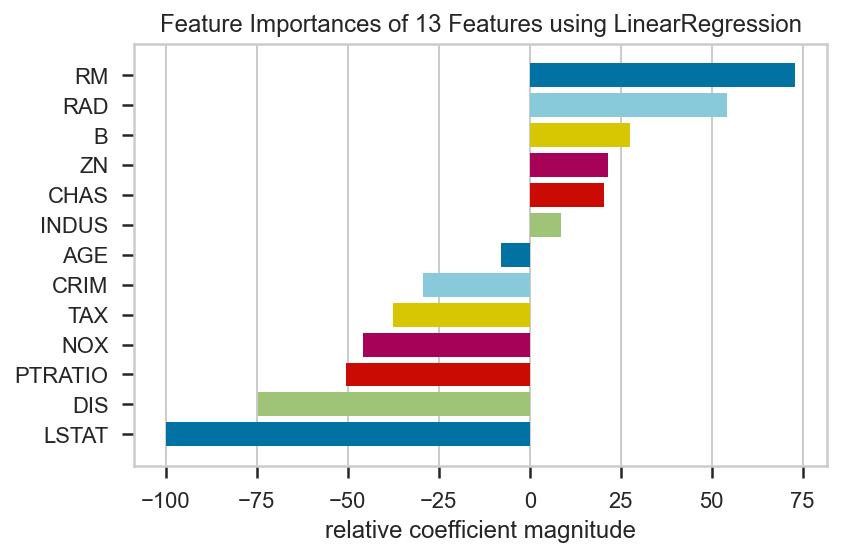

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
viz = FeatureImportances(lr2, labels=bos_sX.columns)
viz.fit(bos_sX, bos_y)
viz.poof()
plt.show()

### SVMs

In [23]:
from sklearn.svm import SVR

In [26]:
svr = SVR()
svr.fit(bsX_train, bsy_train)
svr.score(bsX_test, bsy_test)

0.6551893976487937

### K-Nearest Neighbor

In [27]:
from sklearn.neighbors import KNeighborsRegressor

In [32]:
knr = KNeighborsRegressor(n_neighbors=5)
knr.fit(bsX_train, bsy_train)
knr.score(bsX_test, bsy_test)

0.7476242635592416

### Decision Tree

In [60]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from IPython.display import Image

In [61]:
dtr = DecisionTreeRegressor(random_state=42, max_depth=3)
dtr.fit(bX_train, by_train)
dtr.score(bX_test, by_test)

0.7435711616336518

In [62]:
dtr.score(bX_train, by_train)

0.8251584424966962

In [63]:
dot_data = StringIO()

In [64]:
export_graphviz(
    dtr,
    out_file=dot_data,
    feature_names=bX_train.columns,
    filled=True
)

g = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [65]:
Image(g.create_png())

InvocationException: GraphViz's executables not found

### Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(bX_train, by_train)
rfr.score(bX_test, by_test)

0.8708997131330258

### XGBoost Regression

In [69]:
import xgboost as xgb

In [70]:
xgr = xgb.XGBRegressor(random_state=42)
xgr.fit(bX_train, by_train)
xgr.score(bX_test, by_test)

0.876009538173606

## Chapter 15. Metrics and Regression Evaluation


In [74]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(bX_train, by_train)

by_pred = rfr.predict(bX_test)

### Metrics

In [75]:
from sklearn import metrics

In [76]:
rfr.score(bX_test, by_test)

0.8708997131330258

In [77]:
metrics.r2_score(by_test, by_pred)

0.8708997131330258

In [78]:
metrics.mean_absolute_error(by_test, by_pred)

2.083605263157894

In [79]:
metrics.mean_squared_error(by_test, by_pred)

9.619662013157892

The `mean squared logarithmic error` penalizes underprediction more than overprediction.<br> 
If you have targets that experience exponential growth<br>
(population, stock, etc.), this is a good metric.

In [94]:
metrics.mean_squared_log_error(by_test, by_pred)

0.02128735507001923

In [98]:
np.mean(np.square(np.log((by_test+1) / (by_pred+1))))

0.021287355070019227

### Residuals Plots

In [99]:
from yellowbrick.regressor import ResidualsPlot

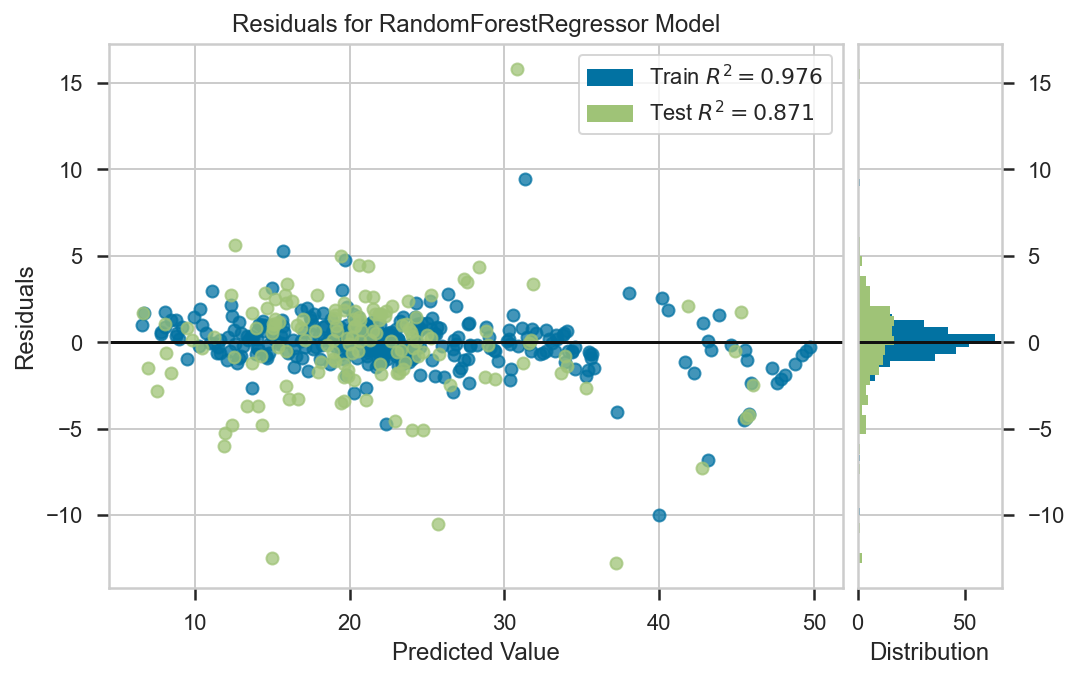

In [101]:
fig, ax = plt.subplots(figsize=(8, 5))
rpv = ResidualsPlot(rfr, ax=ax)
rpv.fit(bX_train, by_train)
rpv.score(bX_test, by_test)
rpv.poof()
plt.show()

### Heteroscedasticity

variance of the residuals varies over the predicted values.<br>
In the Breusch-Pagan test, if the p-values are significant<br>
(p-value less than 0.05), the null hypothesis of homoscedasticity is rejected.<br>
This indicates that residuals are heteroscedastic, and the predictions are<br>
biased.


In [102]:
import statsmodels.stats.api as sms

In [105]:
hb = sms.het_breuschpagan((by_test - by_pred), bX_test)
labels = [
    "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value"
]
for lbl, num in zip(labels, hb):
    print(f"{lbl}: {num:.2}")

Lagrange multiplier statistic: 3.5e+01
p-value: 0.00041
f-value: 3.2
f p-value: 0.00027


### Normal Residuals

In [111]:
from scipy import stats

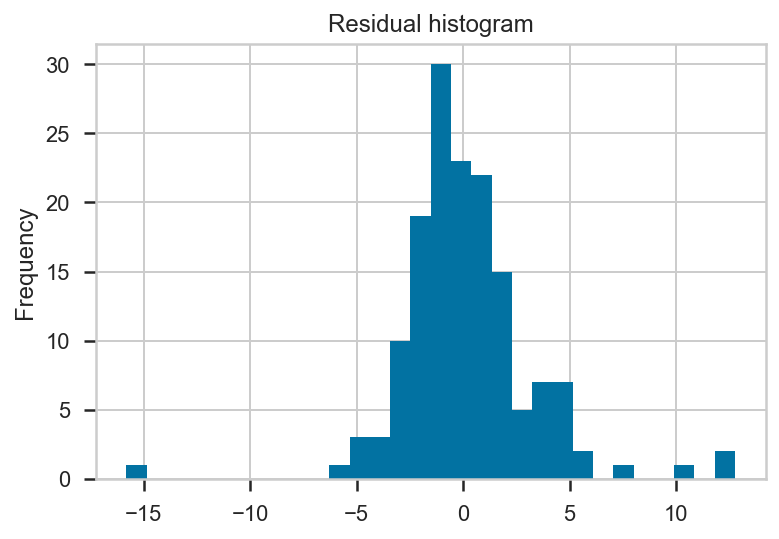

In [110]:
fig, ax = plt.subplots(figsize=(6, 4))
resids = by_test - by_pred
pd.Series(resids, name='residuals').plot.hist(
    bins=30,
    ax=ax,
    title='Residual histogram'
)
plt.show()

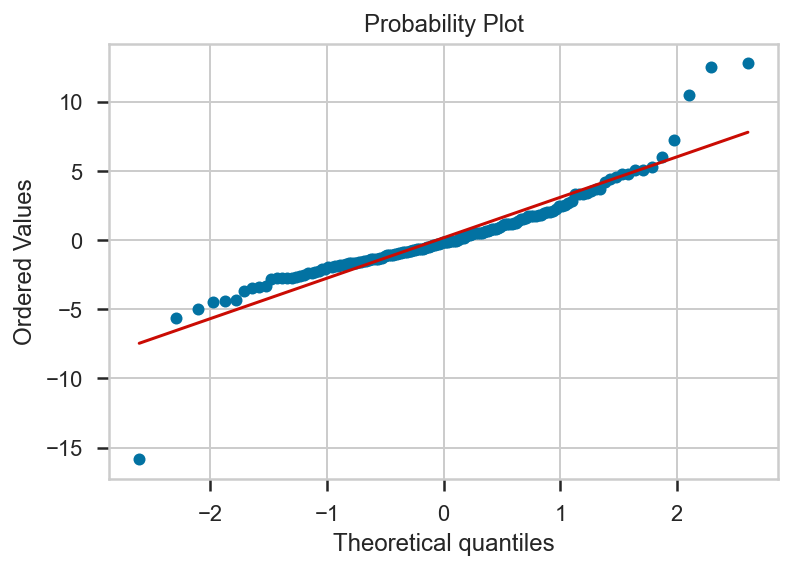

In [112]:
fig, ax = plt.subplots(figsize=(6, 4))
_ = stats.probplot(resids, plot=ax)
plt.show()

The Kolmogorov-Smirnov test can evaluate whether a distribution is normal. <br>
If the p-value is significant (< 0.05), then the values are not normal.<br>
This fails, which tells us the residuals are not normal:

In [114]:
stats.kstest(resids, cdf='norm')

KstestResult(statistic=0.2030324289045929, pvalue=5.705755737845543e-06)

### Prediction Error Plot

In [115]:
from yellowbrick.regressor import PredictionError

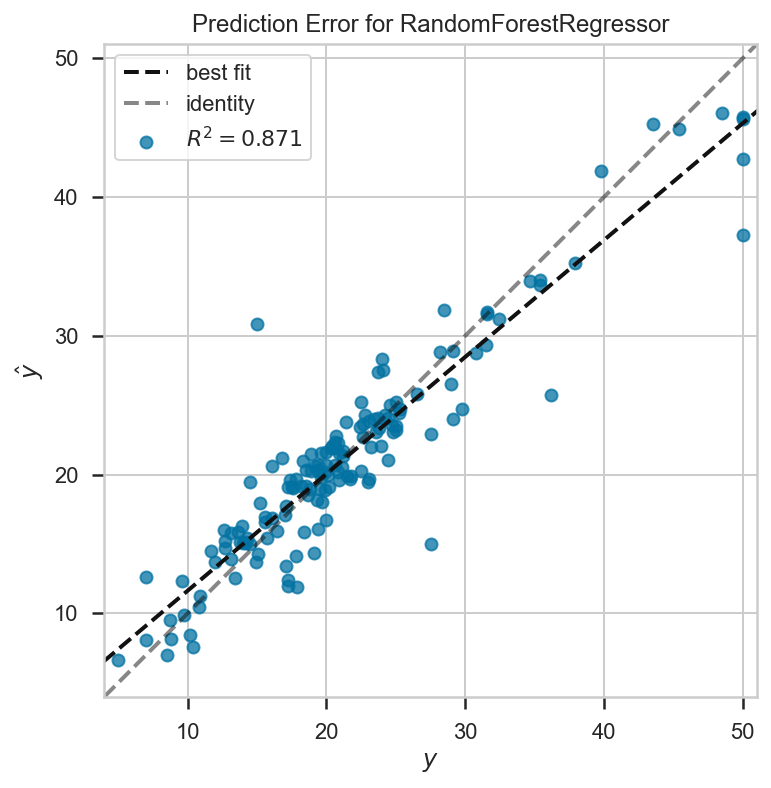

In [116]:
fig, ax = plt.subplots(figsize=(6, 6))
pe = PredictionError(rfr, ax=ax)
pe.fit(bX_train, by_train)
pe.score(bX_test, by_test)
pe.poof()
plt.show()

## Chapter 16. Explaining Regression Models